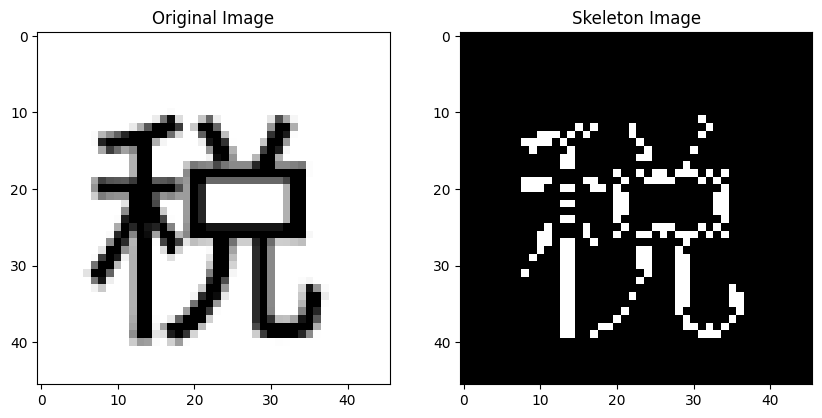

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def skeletonize(image):
    # 二値化された画像が必要なので、まずは閾値処理を行う
    ret, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

    # スケルトン化処理のために必要な変数を初期化
    skeleton = np.zeros(binary_image.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False

    while not done:
        # クロージング（膨張後に収縮）を適用
        eroded = cv2.erode(binary_image, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(binary_image, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        binary_image = eroded.copy()

        # 全てのピクセルが消えたら終了
        if cv2.countNonZero(binary_image) == 0:
            done = True

    return skeleton

def main():
    # 画像の読み込み（グレースケール）
    image = cv2.imread('./zei.png', cv2.IMREAD_GRAYSCALE)

    # スケルトン化処理
    skeleton = skeletonize(image)

    # 結果を表示
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Skeleton Image")
    plt.imshow(skeleton, cmap='gray')
    plt.show()

    # スケルトン画像を保存
    cv2.imwrite('./zei_skeleton.png', skeleton)

if __name__ == "__main__":
    main()


### ストロークを取り除く: テスト

In [ ]:
import xml.etree.ElementTree as ET
import os

def char2kanji_id(char):
    # Convert a character to its four-digit hexadecimal Unicode code point string without the 'x'
    return 'kvg:kanji_0' + format(ord(char), '04X')
def char2code(char):
    return format(ord(char), '#06x')

target_character = '士' # target chars
#output_root = f'../PRMU/simclr/data/{char2code(target_character)}/'
output_root = f'./OUTPUT/'
side_length = 170 # The original size of kanjiVG is 109*109, and expanded to side_length*side_length
stroke_width = 4
index = '08'
root = ET.parse('kanjivg-20230110.xml') # XML data

target_kanji_id = char2kanji_id(target_character).lower()
output_folder = os.path.join(output_root, target_kanji_id)

#target_code = char2code(target_character)

# Namespace Dictionary
namespaces = {'kvg': 'http://kanjivg.tagaini.net'}

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Creating SVG Files
svg_header = f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 109 109" width="{side_length}" height="{side_length}">'
svg_background = '<rect width="100%" height="100%" fill="white"/>'
svg_footer = '</svg>'
svg_content1 = svg_background
svg_content2 = svg_background

#colors = ["red", "green", "blue", "orange", "purple", "brown", "black"]
colors = ["black"]*7

color_index = 0
all_control_points = []

# 取り除きたいストローク: 何画目

for kanji in root.findall(".//kanji[@id='" + target_kanji_id + "']", namespaces=namespaces):
    # Process the found kanji elements
    # print("Found kanji with id:", target_kanji_id)
    for path in kanji.findall('.//path', namespaces=namespaces):
        stroke_id = path.get('id')
        stroke_d = path.get('d')
        
        stroke_svg = svg_content1 + f'<path id="{stroke_id}" d="{stroke_d}" fill="none" stroke="black" stroke-width="{stroke_width}" stroke-linecap="round"/>\n'
        stroke_svg = svg_header + stroke_svg + svg_footer

        # Write the SVG content to a file and save the file in the specified folder
        r_folder = os.path.join(output_folder, 'reference_single_image')
        if not os.path.exists(r_folder):
            os.makedirs(r_folder)
        
        # kvg:xxxx-s1 -> kvg:xxxx-s01
        prefix, idx = stroke_id.rsplit('-s', 1)  # 分离出前缀和stroke_id部分
        stroke_id = f'{prefix}-s{int(idx):02}' # 将stroke_id格式化为两位数
        
        if stroke_id == f'{prefix}-s{index}':
            continue

        filename = os.path.join(r_folder, f'{stroke_id}.svg')
        with open(filename, 'w') as file:
            file.write(stroke_svg) # Save single-stroke
        print(f"SVG file created for stroke {stroke_id}: {filename}")

        color = colors[color_index % len(colors)]
        color_index += 1
        if stroke_id == f'{prefix}-s{index}':
            color = "red"
        svg_content2 += f'<path id="{stroke_id}" d="{stroke_d}" fill="none" stroke="{color}" stroke-width="{stroke_width}" stroke-linecap="round"/>\n'

svg_full_content = svg_header + svg_content2 + svg_footer

filename = os.path.join(output_folder, target_kanji_id + '.svg')

with open(filename, 'w') as file:
    file.write(svg_full_content)  # Save complete-char

print(f"All strokes for kanji {target_kanji_id} are saved in one SVG file: {filename}")

### ストロークを取り除く: データセット作成

In [56]:
import xml.etree.ElementTree as ET

output_root = '../PRMU/simclr/data/train'
test_dir = '../PRMU/simclr/data/test'
side_length = 170 # The original size of kanjiVG is 109*109, and expanded to side_length*side_length
stroke_width = 4
root = ET.parse('kanjivg-20230110.xml')

# 名前空間を設定
namespaces = {'kvg': 'http://kanjivg.tagaini.net'}

def char2kanji_id(char):
    # Convert a character to its four-digit hexadecimal Unicode code point string without the 'x'
    return 'kvg:kanji_0' + format(ord(char), '04X')
def char2code(char):
    return format(ord(char), '#06x')
def kanji_id2char(kanji_id):
    code = kanji_id.replace('kvg:kanji_', '')
    return chr(int(code, 16))
def is_kanji(char):
    if '\u4E00' <= char <= '\u9FFF':
        return True
    else:
        return False

# Creating SVG Files
svg_header = f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 109 109" width="{side_length}" height="{side_length}">'
svg_background = '<rect width="100%" height="100%" fill="white"/>'
svg_footer = '</svg>'
svg_content1 = svg_background
svg_content2 = svg_background

# テストデータの漢字を取得
test_data = os.listdir(test_dir)
# すべての漢字を取得（<kanji> 要素）
for kanji in root.findall(".//kanji", namespaces=namespaces):
    kanji_id = kanji.get('id')
    char = kanji_id2char(kanji_id)
    Unicode = char2code(char)
    
    if not is_kanji(char):
        continue
    if Unicode in test_data:
        continue
        
    # すべてのストロークを取得
    paths = kanji.findall('.//path', namespaces=namespaces)
    if len(paths) <= 1:
        continue  # 一画以下は次へ
    
    output_folder = os.path.join(output_root, Unicode)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    #number = len(os.listdir(output_folder))

    # ランダムに1ストロークを選択
    #random_stroke = random.choice(paths)
    # 順番に1ストロークを選択
    for i, chosen_stroke in enumerate([None]+paths):
        # 1ストローク抜けの1文字画像を作成
        for path in paths:
            # 漢字のIDを取得
            stroke_id = path.get('id')
            stroke_d = path.get('d')

            #stroke_svg = svg_content1 + f'<path id="{stroke_id}" d="{stroke_d}" fill="none" stroke="white" stroke-width="{stroke_width}" stroke-linecap="round"/>\n'
            #stroke_svg = svg_header + stroke_svg + svg_footer

            # kvg:xxxx-s1 -> kvg:xxxx-s01
            prefix, idx = stroke_id.rsplit('-s', 1)  # 分离出前缀和stroke_id部分
            stroke_id = f'{prefix}-s{int(idx):02}' # 将stroke_id格式化为两位数

            if path == chosen_stroke:#random_stroke:
                continue
            svg_content2 += f'<path id="{stroke_id}" d="{stroke_d}" fill="none" stroke="black" stroke-width="{stroke_width}" stroke-linecap="round"/>\n'

        svg_full_content = svg_header + svg_content2 + svg_footer
        svg_content2 = ''
        filename = os.path.join(output_folder, f'{Unicode}' + '-' + f'{i}' + '.svg')

        with open(filename, 'w') as file:
            file.write(svg_full_content)  # Save complete-char

In [4]:
import xml.etree.ElementTree as ET
import os

output_root = '../PRMU/simclr/data/test'
test_dir = '../PRMU/simclr/data/test'
side_length = 170 # The original size of kanjiVG is 109*109, and expanded to side_length*side_length
stroke_width = 4
root = ET.parse('kanjivg-20230110.xml')

# 名前空間を設定
namespaces = {'kvg': 'http://kanjivg.tagaini.net'}

def char2kanji_id(char):
    # Convert a character to its four-digit hexadecimal Unicode code point string without the 'x'
    return 'kvg:kanji_0' + format(ord(char), '04X')
def char2code(char):
    return format(ord(char), '#06x')
def kanji_id2char(kanji_id):
    code = kanji_id.replace('kvg:kanji_', '')
    return chr(int(code, 16))
def is_kanji(char):
    if '\u4E00' <= char <= '\u9FFF':
        return True
    else:
        return False

# Creating SVG Files
svg_header = f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 109 109" width="{side_length}" height="{side_length}">'
svg_background = '<rect width="100%" height="100%" fill="white"/>'
svg_footer = '</svg>'
svg_content1 = svg_background
svg_content2 = svg_background

# テストデータの漢字を取得
test_data = os.listdir(test_dir)
# すべての漢字を取得（<kanji> 要素）
for kanji in root.findall(".//kanji", namespaces=namespaces):
    kanji_id = kanji.get('id')
    char = kanji_id2char(kanji_id)
    Unicode = char2code(char)
    
    if not is_kanji(char):
        continue
    if Unicode not in test_data:
        continue
        
    # すべてのストロークを取得
    paths = kanji.findall('.//path', namespaces=namespaces)
    if len(paths) <= 1:
        continue  # 一画以下は次へ
    
    output_folder = os.path.join(output_root, Unicode)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    #number = len(os.listdir(output_folder))

    # ランダムに1ストロークを選択
    #random_stroke = random.choice(paths)
    # 順番に1ストロークを選択
    for i, chosen_stroke in enumerate([None]+paths):
        # 1ストローク抜けの1文字画像を作成
        for path in paths:
            # 漢字のIDを取得
            stroke_id = path.get('id')
            stroke_d = path.get('d')

            #stroke_svg = svg_content1 + f'<path id="{stroke_id}" d="{stroke_d}" fill="none" stroke="white" stroke-width="{stroke_width}" stroke-linecap="round"/>\n'
            #stroke_svg = svg_header + stroke_svg + svg_footer

            # kvg:xxxx-s1 -> kvg:xxxx-s01
            prefix, idx = stroke_id.rsplit('-s', 1)  # 分离出前缀和stroke_id部分
            stroke_id = f'{prefix}-s{int(idx):02}' # 将stroke_id格式化为两位数

            if path == chosen_stroke:#random_stroke:
                continue
            svg_content2 += f'<path id="{stroke_id}" d="{stroke_d}" fill="none" stroke="black" stroke-width="{stroke_width}" stroke-linecap="round"/>\n'

        svg_full_content = svg_header + svg_content2 + svg_footer
        svg_content2 = ''
        filename = os.path.join(output_folder, f'{Unicode}' + '-' + f'{i}' + '.svg')

        with open(filename, 'w') as file:
            file.write(svg_full_content)  # Save complete-char

In [4]:
import shutil
import os

# 削除したいディレクトリのパス
target_directory = '../PRMU/simclr/data/test'

# サブディレクトリの中身を削除する
for subdir in os.listdir(target_directory):
    full_path = os.path.join(target_directory, subdir)
    if os.path.isdir(full_path):
        # サブディレクトリ内のすべてのファイルとフォルダを削除
        for item in os.listdir(full_path):
            item_path = os.path.join(full_path, item)
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)  # フォルダを削除
            elif os.path.isfile(item_path):
                os.remove(item_path)  # ファイルを削除


In [5]:
import cairosvg
from PIL import Image
import io
import glob
import shutil
import os 
path_to_data = '../PRMU/simclr/data/test'

# SVG ファイルを PNG に変換して Pillow で開く ⚠️: SVGに透明度チャンネルが含まれているためRGBAになる
def open_svg_as_image(svg_path):
    # SVGファイルを読み込み、バイトストリームに変換
    png_data = cairosvg.svg2png(url=svg_path)
    image = Image.open(io.BytesIO(png_data))
    image.save(svg_path.replace('svg', 'png'), 'PNG')
    shutil.copy(svg_path.replace('svg', 'png'), os.path.dirname(os.path.dirname(path)))

for path in glob.glob(f'{path_to_data}/*/*.svg'):
    open_svg_as_image(path)

In [68]:
open_svg_as_image('./OUTPUT/kvg:kanji_06b66/kvg:kanji_06b66.svg')

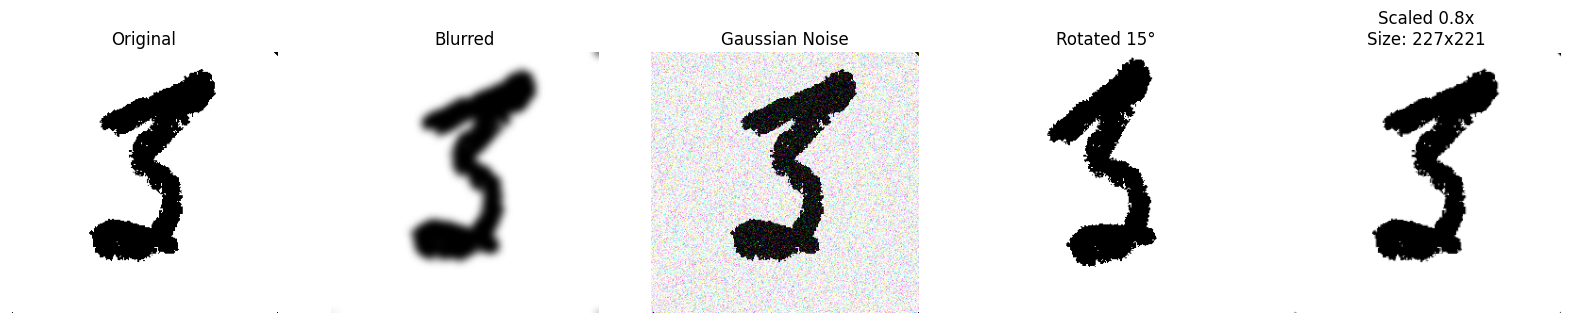

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import random

# 画像を読み込む
#img_path = './OUTPUT/kvg:kanji_06b66/kvg:kanji_06b66.png'
img_path = '../PRMU/simclr/data/test/0x5728/0x5728-0.png'
img_path = '/data2/abababam1/HandwrittenTextAlign/PRMU/toda_char_new_bi/train/0x308b/100_bijogi-2-4_xaas_S2-194.png'

image = Image.open(img_path)

# ブラー加工
blurred_image = image.filter(ImageFilter.GaussianBlur(radius=4))

# ガウシアンノイズを加える関数
def add_gaussian_noise(image_array, mean=0, sigma=25):
    row, col, ch = image_array.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = image_array + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

image_np = np.array(image)
noisy_image_np = add_gaussian_noise(image_np)


class AddGaussianNoiseToImage(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, img):
        # 画像をNumPy配列に変換
        np_img = np.array(img).astype(np.float32)

        # ノイズを追加
        noise = np.random.randn(*np_img.shape) * self.std + self.mean
        np_img = np_img + noise

        # 値が[0, 255]の範囲内に収まるようにクリップ
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)

        # NumPy配列をPIL Imageに戻す
        return Image.fromarray(np_img)

transform = AddGaussianNoiseToImage(mean=0.1, std=50.0)
noisy_image_np = transform(image)


# 回転加工
rotated_image = image.rotate(15, fillcolor=(255, 255, 255))

# 拡大縮小
scaled_image_1 = image.resize((int(image.width * 1.2), int(image.height * 1.2)))
scaled_image_2 = image.resize((int(image.width * 0.8), int(image.height * 0.8)))

# 結果を表示
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# 元の画像
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

# ブラー画像
axes[1].imshow(blurred_image)
axes[1].set_title("Blurred")
axes[1].axis("off")

# ノイズ付き画像
axes[2].imshow(noisy_image_np)
axes[2].set_title("Gaussian Noise")
axes[2].axis("off")

# 回転画像
axes[3].imshow(rotated_image)
axes[3].set_title("Rotated 15°")
axes[3].axis("off")

# 拡大縮小画像
#axes[4].imshow(scaled_image_2)
#axes[4].set_title("Scaled 1.2x")
#axes[4].axis("off")

axes[4].imshow(scaled_image_2)
axes[4].set_title(f"Scaled 0.8x\nSize: {scaled_image_2.size[0]}x{scaled_image_2.size[1]}")
axes[4].axis("off")

plt.show()

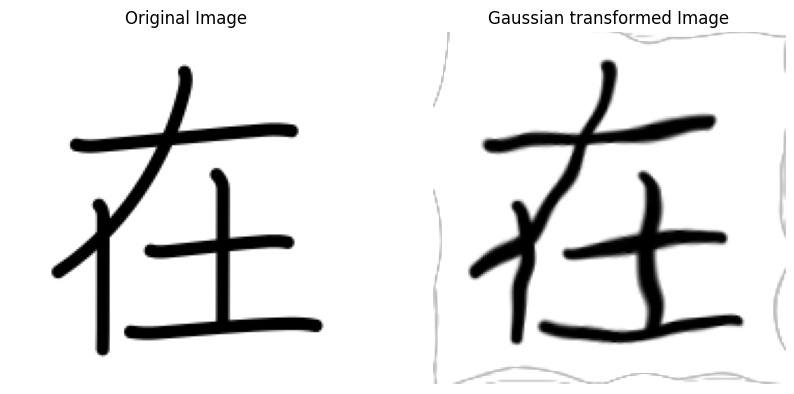

In [41]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt

# 画像を読み込む
img = Image.open('../PRMU/simclr/data/test/0x5728/0x5728-0.png')
#img = Image.open('/data2/abababam1/HandwrittenTextAlign/PRMU/toda_char_new_bi/train/0x308b/100_bijogi-2-4_xaas_S2-194.png')

# GaussianBlurを適用する
gaussian_blur = transforms.GaussianBlur(kernel_size=11, sigma=(0.5, 10.0))
# ElasticTransformを適用する
elastic_transform = transforms.ElasticTransform(alpha=200.0, sigma=10.0, interpolation=InterpolationMode.BILINEAR, fill=255)

# 画像にElasticTransformを適用
transformed_img = elastic_transform(img)
transformed_img = elastic_transform(transformed_img)

# 画像にブラーを適用
#blurred_img = gaussian_blur(img)

# 元の画像とブラー画像を並べて表示
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 元の画像
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# GaussianBlurを適用した画像
axs[1].imshow(transformed_img)
axs[1].set_title('Gaussian transformed Image')
#axs[1].set_title('Gaussian Blurred Image')
axs[1].axis('off')

# 表示
plt.show()

In [ ]:
transforms.ElasticTransform(alpha=50.0, sigma=5.0, interpolation=InterpolationMode.BILINEAR, fill=0)